In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def plot(df, title):
    out = pd.qcut(df["contb_receipt_amt"].astype(float),10, duplicates="drop")
    ax = out.value_counts(sort=False).round(2).plot.bar(x="", rot=70, color="b", figsize=(8,5))
    plt.title(title)
    plt.xlabel("Amount of donation")
    plt.ylabel("Number of donors")
    plt.show()

In [3]:
def election_donations_analysis(input_file):
    from pyspark.sql import SparkSession
    import pyspark.sql.functions as F
    spark = SparkSession.builder.getOrCreate()

    reader = spark.read
    reader.option("header",True).option("inferSchema",True)
    df = reader.csv(input_file)

    cand_info = ['cand_id', 'cand_nm']

    grouped_df = df.groupBy(cand_info)\
        .agg(
            F.count(F.when(F.col('contb_receipt_amt') >= '0', 1)).alias("Dons"),
            F.sum('contb_receipt_amt').alias("Total_cntrb"),
            F.countDistinct(F.when(F.col('contb_receipt_amt') >= '0', F.array('contbr_nm', 'contbr_zip', 'contbr_employer', 'contbr_occupation'))).alias('UqCtb'),
            F.mean("contb_receipt_amt").alias("Mean"),
            F.stddev("contb_receipt_amt").alias("SD"),
            F.count(F.when((F.col('contb_receipt_amt') < '50') & (F.col('contb_receipt_amt') >= '0'), 1)).alias("smCtb")
        ).withColumn("%", (F.col("smCtb") /  F.col("Dons"))*100)

    grouped_df.sort(F.desc('cand_id')).show()
    #grouped_df.write.format('csv').mode('overwrite').save(output_folder1)

    required_cand_ids = ["P80001571", "P80000722"]
    df_6 = df.filter(df.cand_id.isin(required_cand_ids)).filter("contb_receipt_amt >= '0'").select('cand_nm','contb_receipt_amt')

    df_6.sort(F.desc('contb_receipt_amt')).show()
    #df_6.coalesce(1).write.format('csv').mode('overwrite').save(output_folder2)

### Column names are shortened to fit output in single frame, brief description of column names are given below:
cand_id: candidate id, cand_nm = candidate name, Dons = Number of donations(Question1), Total_Cntrb = Total contributions(Question2), UqCtb: Unique Contributions(Question3), Mean and SD: Mean and Standard deviation(Question4), %: Percentage of small contributors(Question5).

Question 1 to 5 are shown in one dataframe. Question 6 is shown in different dataframe

In [4]:
election_donations_analysis("Sampledata.csv")

+---------+--------------------+-----+------------------+-----+------------------+------------------+-----+------------------+
|  cand_id|             cand_nm| Dons|       Total_cntrb|UqCtb|              Mean|                SD|smCtb|                 %|
+---------+--------------------+-----+------------------+-----+------------------+------------------+-----+------------------+
|P80006117|   Klobuchar, Amy J.| 1016|         132880.82|  983|  129.135879494655|437.92921990058244|  489| 48.12992125984252|
|P80001571|    Trump, Donald J.|35391|2776724.1700000004|33836| 74.71542810246476| 350.2942622041361|22899| 64.70289056539798|
|P80000722|  Biden, Joseph R Jr|34307| 3714637.369999998|32838|107.33464430189545|325.79652326238295|20112| 58.62360451219868|
|P60007168|    Sanders, Bernard|13794|452818.75999999995|12777| 32.60738532440411| 111.4194443009164|11371|  82.4343917645353|
|P00016741|         West, Kanye|   10|            1960.0|   10| 178.1818181818182|144.90122027216898|    0|    

# AWS CLI EXPORTED:
aws emr create-cluster --applications Name=Hadoop Name=Spark --ec2-attributes '{"InstanceProfile":"EMR_EC2_DefaultRole","SubnetId":"subnet-640de319","EmrManagedSlaveSecurityGroup":"sg-059957ae2a41c12d0","EmrManagedMasterSecurityGroup":"sg-024494bc483b4f534"}' --release-label emr-6.2.0 --log-uri 's3n://aws-logs-465407365989-us-east-2/elasticmapreduce/' --steps '[{"Args":["spark-submit","--deploy-mode","client","s3://assignment2-825893660/assignment2.py","-i","s3://election-data-usa/P00000001-ALL.csv","-o1","s3://assignment2-825893660/myOutputFolder1","-o2","s3://assignment2-825893660/myOutputFolder2"],"Type":"CUSTOM_JAR","ActionOnFailure":"CONTINUE","Jar":"command-runner.jar","Properties":"","Name":"Spark application"}]' --instance-groups '[{"InstanceCount":1,"EbsConfiguration":{"EbsBlockDeviceConfigs":[{"VolumeSpecification":{"SizeInGB":32,"VolumeType":"gp2"},"VolumesPerInstance":2}]},"InstanceGroupType":"MASTER","InstanceType":"m5.xlarge","Name":"Master Instance Group"},{"InstanceCount":2,"EbsConfiguration":{"EbsBlockDeviceConfigs":[{"VolumeSpecification":{"SizeInGB":32,"VolumeType":"gp2"},"VolumesPerInstance":2}]},"InstanceGroupType":"CORE","InstanceType":"m5.xlarge","Name":"Core Instance Group"}]' --configurations '[{"Classification":"spark","Properties":{}}]' --auto-terminate --service-role EMR_DefaultRole --enable-debugging --name 'Final cluster' --scale-down-behavior TERMINATE_AT_TASK_COMPLETION --region us-east-2

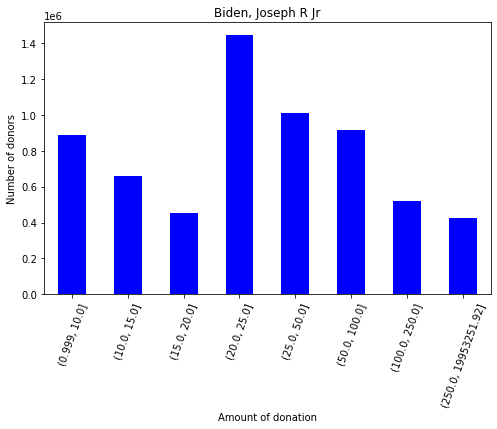

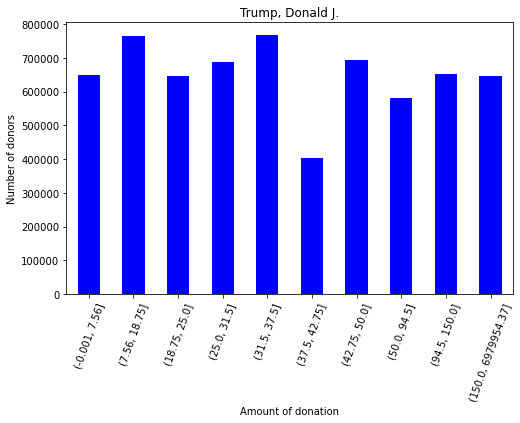

In [5]:
df_6 = pd.read_csv('6_processed_aws.csv', names=["cand_nm", "contb_receipt_amt"])

plot(df_6[df_6['cand_nm']=='Biden, Joseph R Jr'], 'Biden, Joseph R Jr')
plot(df_6[df_6['cand_nm']=='Trump, Donald J.'], 'Trump, Donald J.')

From 2 graphs shown above it can be analysed that both Biden and Trump have similar trends that Number of small contributors (people who contributed less than $50) are more.